In [1]:
using Random, Statistics, PyPlot, Polynomials

# finding π

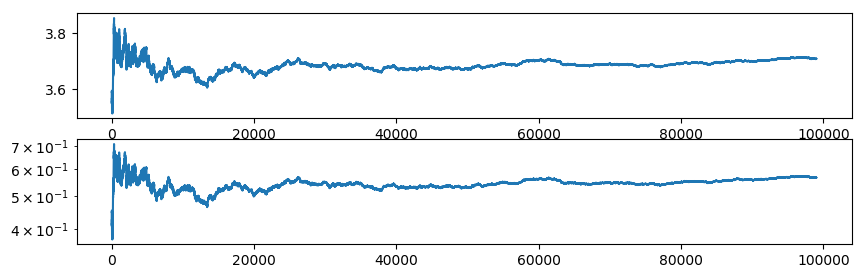

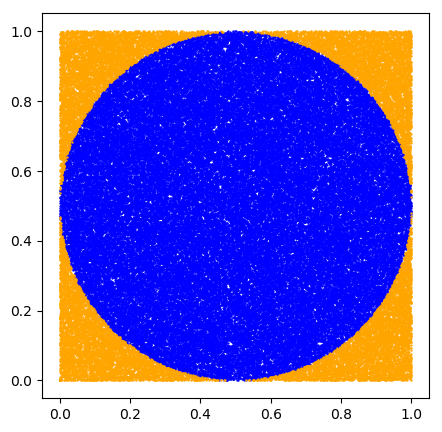

3.7080979284369113

In [36]:
numOfIterations = 100000
xs_i = zeros(Float64,numOfIterations)
ys_i = zeros(Float64,numOfIterations)
xs_o = zeros(Float64,numOfIterations)
ys_o = zeros(Float64,numOfIterations)
my_pi = zeros(Float64,numOfIterations)
inside = 0.
outside = 0. 

for i in range(1,stop = numOfIterations)
    x = rand(Float64)
    y = rand(Float64)
    if (x-0.5)^2 + (y-0.5)^2 < 0.5^2 #inside the circle
        xs_i[i] = x
        ys_i[i] = y
        inside += 1.
    else
        xs_o[i] = x
        ys_o[i] = y
        outside += 1.
    end
    
    my_pi[i] =   (inside / outside)
    
    
end
fig, ax = subplots(2,1, figsize=(10,3))


ax[1].plot(my_pi[1000:end])

ax[2].plot(abs.(my_pi[1000:end] .- π))
yscale("log")
fig,ax = subplots(1,1,figsize=(5,5))
ax.scatter(xs_i,ys_i,color="blue",s=0.5)
ax.scatter(xs_o,ys_o,color="orange",s=0.5)
my_pi[end]

# XY MonteCarlo

In [2]:
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

NearestNeighbors (generic function with 1 method)

In our case, the configuration will be....  just an angle - meaning a number between 0 and 2π.


In [19]:
function XYConfigurationEnergy(lat::SquareLattice, c::Vector{Int64})
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    for j in range(1, length = N)
        nn = NearestNeighbors(lat, j)
        Ec += sum(map(x->cos(c[j]-c[x]),nn)) #Verify this 🎈
    end
    return Ec/2 # in the summation above every bond is included twice
end

XYConfigurationEnergy (generic function with 1 method)

In [ ]:
function XYWolffUpdate!(lat::SquareLattice, c::Vector{Int64}, T::Float64)

    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    #define a random direction: ̂e
    dierection = rand(Float64)*2π
    
    
            
    ind = rand(1:N) # pick a random site

    cluster = Int64[] # indices of spins in the cluster
    newlyAdded = Int64[] # indices of newly added neighbors

    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        if j in cluster
            continue
        end
        si_e = cos(c[i]-diraction) # this gives the projection of si on ̂e 
        sj_e = cos(c[j]-diraction) # this gives the projection of sj on ̂e 
        p = 1. - exp(-2/T * si_e*sj_e)
        if rand() < p # if si_e and sj_e are unti-aligned  p will be negative (i might want to check this!🎈)    
            push!(cluster, j)
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
        end
    end

    #c[cluster] = 1 .- c[cluster] # flip the cluster
    ##🎈 c[cluster] = c[cluster] - 2 (c[cluster]̂⋅e)̂e 
end

In [20]:
function XYMC(lat::SquareLattice, T::Float64, Nsw::Int64, saveConfigs = false)
    # Nsw is the number of sweeps to perform
    
    c = rand(Float64, length(lat)) * 2π

    if saveConfigs
        configs = zeros(Int64, Nsw, length(lat))
        configs[1, :] = c
    end
    
    m = zeros(Float64, Nsw) # absolute value of the magnetization per site
    🧨m[1] = abs( mean(2*c .- 1) )
    
    En = zeros(Float64, Nsw)
    En[1] = IsingConfigurationEnergy(lat, c)
    
    for i in range(2, stop=Nsw)
        XYWolffUpdate!(lat, c, T)
        En[i] = XYConfigurationEnergy(lat, c)
        
        if saveConfigs
            configs[i, :] = c
        end

        🧨m[i] =  abs( mean(2*c .- 1) )

    end
    
    if saveConfigs
        return m, En, configs
    else
        return m, En
    end
    
end

XYMC (generic function with 2 methods)